In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..") 
import importlib
import functions.calc_unit_conversion as uc
import functions.calc_gravitional_potential as cg
importlib.reload(uc)
importlib.reload(cg)
import sympy as sp
from sympy.physics import units
from sympy.physics.units.systems import SI
from sympy.physics.units import Quantity

dpi = 400

plt.rcParams['figure.dpi'] = dpi

plt.rcParams['savefig.dpi'] = dpi
plt.style.use(['science','ieee'])
plt.rcParams['figure.figsize'] = 5, 5
plt.rcParams["text.usetex"] = False

In [2]:
# set front color for simpy output
sp.init_printing(use_latex='svg', forecolor='black',scale=1)


# Get unit from simpy value
def unit(expr):
    return expr.subs({x: 1 for x in expr.args if not x.has(Quantity)})


In [3]:
#%% Constants

### boltzmann_constant
kB = units.boltzmann_constant.convert_to(units.meter **2 * units.kg * units.second ** -2 * units.K ** -1)

### Magnetic constant
mu = units.magnetic_constant.convert_to(units.m * units.kg * units.s** -2 * units.ampere ** -2)

### Solar mass
Msun = units.Quantity(r"Msun")
SI.set_quantity_dimension(Msun, units.mass)
SI.set_quantity_scale_factor(Msun, 1.98847*10**30*units.kg)

### Parsec
pc = units.Quantity("pc")
SI.set_quantity_dimension(pc, units.length)
SI.set_quantity_scale_factor(pc, 3.08567758*10**16*units.meter)


### Gravitational constant
G = units.gravitational_constant.convert_to(units.km**2*pc/(units.s**2*Msun))


### boltzmann_constant
kB = units.boltzmann_constant.convert_to(units.meter **2 * units.kg * units.second ** -2 * units.K ** -1)

### Hydrogen Mass
Hmass = 1.6735575 * 10 ** -24 * units.gram

In [4]:

def plummer_density(r: np.ndarray, r_flat: float, rho_c: float) -> np.ndarray:
    """ 
        Function to calculate the plummer density profile assuming p = 2.
        :param r: radius from the origin, [pc]
        :param  r_flat: characteristic length, [pc]
        :param rho_c: center density [Msun.pc-3]
        :return: density profile [Msun.pc-3] 
    """
    A = (1 + (r/ r_flat) ** 2)
    
    return rho_c / A

def create_unit_sample(nx: int, ny: int, nz: int, Lx: float, Ly: float, Lz: float, L_cloud: float, r_flat: float = 1) -> np.ndarray:
    """ 
        :param nx, ny, nz: number of grids in the three directions
        :param Lx, Ly, Lz: domain size [pc]
        :param L_cloud: length of the cloud [pc]
        :param r_flat: characteristic length, [pc]
        :return: relative density of each grid [dimensionless]
    """
    dx = Lx/(nx)
    dy = Ly/(ny)
    dz = Lz/(nz)
    
    x = np.arange(0, Lx, dx) - Lx/2 + dx/2
    y = np.arange(0, Ly, dy) - Ly/2 + dy/2
    z = np.arange(0, Lz, dz) - Lz/2 + dz/2

    X, Y, Z = np.meshgrid(x, y, z)
    
    ### Radial cooridinate.
    R = np.sqrt(X ** 2 + Y ** 2)
    
    ### Desnity profile
    density = plummer_density(R, r_flat, 1)
    
    ### maximum density in this domain
    max_den = plummer_density(5, r_flat, 1)
    
    ### Exponential decay in the two end
    density = np.multiply(density, np.where(np.abs(Z) > L_cloud/2, np.exp(-(L_cloud/20)*(abs(Z) - L_cloud/2)), 1))
    
    ### fill minimum value
    density[density < max_den] = max_den
    
    return density, R

In [5]:
### Calculate for input values

### for center density
sym_rho_c = sp.Symbol('rho_c')

### for magnetic field strength
sym_B = sp.Symbol('B')


In [6]:
### nMesh of the domain
N = 128

nx, ny = N/2, N/2
nz = N

### length of the domain [pc]
Lx, Ly = 10, 10 
Lz = 20

### length of the cloud [pc]
L_cloud = 15

dx = Lx/nx 
dy = Ly/ny 
dz = Lz/nz 

dV = dx*dy*dz * pc ** 3

r_flat = 1

# sonic mach number
Mach = 10 

### Temperature
T = (25) * units.kelvin

### unit density [no unit]
unit_den, radius = create_unit_sample(nx, ny, nz, Lx, Ly, Lz, L_cloud, r_flat = r_flat)

### unit mass [pc-3]
unit_mass = np.sum(unit_den) * dV 

### total mass [Msun]
mass = unit_mass * sym_rho_c

print("Mass in terms of center density is", mass)

Mass in terms of center density is 197.067848216118*pc**3*rho_c


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times


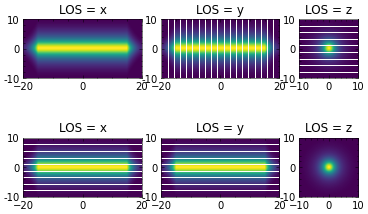

In [7]:
extent = [[-20, 20, -10, 10], [-20, 20, -10, 10], [-10, 10, -10, 10]]
title = ["x", "y", "z"]

fig, axs = plt.subplots(2, 3, gridspec_kw={'width_ratios': [2, 2, 1]})



for los in range(3):
    axs[0][los].imshow(np.sum(unit_den, los), extent = extent[los])
    # if los < 2:
    #     for i in np.linspace(-5, 5, 10):
    #         ax[los].hlines(i, -10, 10, color = 'white')
    if los == 1:
        for i in np.linspace(-20, 20, 20):
            axs[0][los].vlines(i, -10, 10, color = 'white')
    elif los == 2:
        for i in np.linspace(-10, 10, 10):
            axs[0][los].hlines(i, -10, 10, color = 'white')
    axs[0][los].grid(False)
    axs[0][los].set_title("LOS = " + title[los])
    axs[0][los].set_yticks([-10, 0, 10], [-10, 0, 10])
    

for los in range(3):
    axs[1][los].imshow(np.sum(unit_den, los), extent = extent[los])
    if los < 2:
        for i in np.linspace(-10, 10, 10):
            axs[1][los].hlines(i, -20, 20, color = 'white')
    axs[1][los].grid(False)
    axs[1][los].set_title("LOS = " + title[los])
    axs[1][los].set_yticks([-10, 0, 10], [-10, 0, 10])
plt.show()



In [8]:
#%% Calculate GPE 

### Calculate the portential field [without Gravitional constant]
GP = cg.CalGPE(unit_den, cell_size = dx)

### Calculate total energy
GPE = 1/2 * G * np.sum(GP*unit_den) * dV * sym_rho_c ** 2  * pc ** 2
print("Total gravitational potential energy is ", GPE)

Total gravitational potential energy is  -15.3600801826828*kilometer**2*pc**6*rho_c**2/(Msun*second**2)


In [9]:
### sound speed
sound_speed = sp.sqrt(kB * T / (2.3 * Hmass)).n()
sound_speed = units.convert_to(sound_speed, [units.km / units.s])

print('sound speed is =', sound_speed)

### Mach number is 10
v = Mach*sound_speed

### turbulent kinetic energy
KE = 1/2* mass * v ** 2
print("Turbulent kinetic energy is ", KE)

sound speed is = 0.299452131306179*kilometer/second
Turbulent kinetic energy is  883.569255429953*kilometer**2*pc**3*rho_c/second**2


In [21]:
### Solve for center density
### center density
center_density = sp.solve(KE + GPE, sym_rho_c)[1]
print("Center density is ", center_density)

### in units of number density
center_density_npcc = uc.volume_den_Msun_per_pc3_to_number_den_H2_per_cm3(center_density/Msun*pc**3, mu = 2.3)
print("                = ", center_density_npcc, "H2.cc-1")


Center density is  57.5237397800894*Msun/pc**3
                =  966.149813404891 H2.cc-1


In [22]:
#%% Calculate magnetic field strength

### Expression of magnetic energy
BE = sym_B ** 2 / 2 / mu  *  Lx*Ly*Lz * pc ** 3
print("Magneic energy is", BE)


### Solve for B
B = sp.solve(BE + GPE.subs(sym_rho_c, center_density), sym_B)[1]
print(B)

B = units.convert_to(B, [units.tesla])

print("Magnetic field strength is", B)
print("Magnetic field strength is", B/units.tesla * 10 ** 10, "muG")

B_code = uc.b_muG_to_b_code(B/units.tesla * 10 ** 10)

print("Magnetic field strength is", B_code, "[code]")

Magneic energy is 2500000000*ampere**2*pc**3*second**2*B**2/(pi*kilogram*meter)
1.04559487843513e-39*Msun/(ampere*second**2)
Magnetic field strength is 2.0791340479219e-9*tesla
Magnetic field strength is 20.7913404792190 muG
Magnetic field strength is 7.29448508436789 [code]


In [23]:
#%% Free fall time

t_ff = sp.sqrt(3 * sp.pi / 32 / G / center_density)
t_ff = units.convert_to(t_ff, units.year)

print("Free fall times is ", uc.time_Myrs_to_code(t_ff.n()/units.year / 10 ** 6), '[code unit]')

Free fall times is  1.04338508987701 [code unit]


In [34]:
mass_per_unit_length_crit = 2 * (sound_speed)**2 / (uc.GRAVCONST * units.km**2 * pc * units.s**-2 *Msun ** -1)

mass_per_unit_length = center_density * unit_den[:,:,32][radius[:,:,0] < r_flat].sum() * dx**2  *pc**2

print(f"critical mass per unit length is =", mass_per_unit_length_crit )
print(f"mass per unit length is          =", mass_per_unit_length )
print(f"criticality is                   = {mass_per_unit_length / mass_per_unit_length_crit}" )

critical mass per unit length is = 41.6970444508676*Msun/pc
mass per unit length is          = 121.960575371558*Msun/pc
criticality is                   = 2.92492134581064


In [71]:
class cloud:
    def __init__(
        self, 
        name: str, 
        mass: float, 
        length: float,
        ref: str,
        line_mass: float = None
        ) -> None:
        self.name = name
        self.mass = mass
        self.length = length
        self.mass_per_unit_length = line_mass if line_mass else mass/length
        self.ref = ref
    def __repr__(self):
        return (
            f"{self.name} \n" + \
            f"mass                 = {self.mass:10.2f} Msun\n" +\
            f"length               = {self.length:10.2f} pc\n" +\
            f"mass per unit length = {self.mass_per_unit_length:10.2f} Msun.pc-1\n"
        )


In [73]:
orion_b = cloud("Orion B", 10**5, np.sqrt(1500), "https://doi.org/10.1111/j.1365-2966.2009.15619.x")

orion_a = cloud("Orion A", 10**5, 90, "https://doi.org/10.1111/j.1365-2966.2009.15619.x")

musca = cloud("Musca", 0,0, "https://www.aanda.org/articles/aa/pdf/2016/02/aa26017-15.pdf", line_mass=43)

In [74]:
print(orion_b)
print(orion_a)
print(musca)

Orion B 
mass                 =  100000.00 Msun
length               =      38.73 pc
mass per unit length =    2581.99 Msun.pc-1

Orion A 
mass                 =  100000.00 Msun
length               =      90.00 pc
mass per unit length =    1111.11 Msun.pc-1

Musca 
mass                 =       0.00 Msun
length               =       0.00 pc
mass per unit length =      43.00 Msun.pc-1

